In [1]:
import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
import os

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from modules.data import Dataset_WeatherBench_1D, WeatherBenchDataset, load_test_data
from modules.models import SphericalCNN
from modules.test import create_predictions, compute_weighted_rmse, assess_model

In [3]:
datadir = "/mnt/scratch/students/illorens/data/"

label_path = datadir + "5.625deg/"
train_path = datadir + "train/"
val_path = datadir + "val/"
test_path = datadir + "test/"

model_save_path = datadir + "predictions/models/"
pred_save_path = datadir + "predictions/"
evaluation_path = datadir + "predictions/model_evaluation/"

train_years=('1979', '2015')
valid_years=('2016', '2016')
test_years=('2017', '2018')

z = xr.open_mfdataset(f'{label_path}geopotential_500/*.nc', combine='by_coords')
lat = z.lat
lon = z.lon
var_dict = {var: None for var in ['z', 't']}

nodes = len(lat) * len(lon)
ratio = len(lon)/len(lat)

In [4]:
def init_device(model, gpu=None):
    """Initialize device based on cpu/gpu and number of gpu
    Args:
        device (str): cpu or gpu
        ids (list of int or str): list of gpus that should be used
        unet (torch.Module): the model to place on the device(s)
    Raises:
        Exception: There is an error in configuring the cpu or gpu
    Returns:
        torch.Module, torch.device: the model placed on device, the device
    """
    
    if torch.cuda.is_available():
        if gpu is None:
            device = torch.device("cuda")
            model = model.to(device)
            model = nn.DataParallel(model)
        elif len(gpu) == 1:
            device = torch.device("cuda:{}".format(gpu[0]))
            model = model.to(device)
        else:
            device = torch.device("cuda:{}".format(gpu[0]))
            model = model.to(device)
            model = nn.DataParallel(model, device_ids=[int(i) for i in gpu])
    else:
        device = torch.device("cpu")
        model = model.to(device)

    return model, device


def train_model(model, device, train_generator, epochs, lr, validation_data, patience):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, eps=1e-7, weight_decay=0, amsgrad=False)
    
    min_val_loss = 1e15
    wait = 0
    stopped_epoch = 0
    stop_training = False
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        time1 = time.time()
        
        val_loss = 0
        train_loss = 0
        
        model.train()
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            batch_size = batch.shape[0]
            
            # Model
            output = model(batch)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + loss.item() * batch_size
            
        train_loss = train_loss / (len(train_generator.dataset))
        train_losses.append(train_loss)
        
        model.eval()
        with torch.set_grad_enabled(False):
            for batch, labels in validation_data:
                # Transfer to GPU
                batch, labels = batch.to(device), labels.to(device)
                
                batch_size = batch.shape[0]
                
                output = model(batch)

                val_loss = val_loss + criterion(output, labels).item() * batch_size
                
        val_loss = val_loss / (len(validation_data.dataset))
        val_losses.append(val_loss)
        
        time2 = time.time()
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=epochs, l=train_loss, v_l=val_loss, t=time2-time1))
                
        '''
        if (val_loss - min_val_loss) < 0:
            min_val_loss = val_loss
            wait = 0
        else:
            if wait >= patience:
                stopped_epoch = epoch + 1
                stop_training = True
            wait += 1
        
        if stop_training:
            print('Epoch {e:3d}: early stopping'.format(e=stopped_epoch))
            return train_losses, val_losses'''
        
    return train_losses, val_losses

## 3 day prediction

In [7]:
lead_time = 72
valid = load_test_data(f'{label_path}', lead_time)
valid_time = z.sel(time=slice(*test_years)).isel(time=slice(lead_time, None)).time

batch_size = 128



### Dataset with xarray
z = xr.open_mfdataset(f'{datadir}geopotential_500/*.nc', combine='by_coords')  
t = xr.open_mfdataset(f'{datadir}temperature_850/*.nc', combine='by_coords')  
ds = xr.merge([z, t], compat='override')  # Override level. discarded later anyway.  

lat = ds.dims['lat']  
lon = ds.dims['lon']  
nodes = lat * lon  
ratio = lon/lat  

ds_train = ds.sel(time=slice(*train_years))  
ds_valid = ds.sel(time=slice(*valid_years))  
ds_test = ds.sel(time=slice(*test_years))  

dic = {var: None for var in vars}  

dataset_train = Dataset_WeatherBench_1D(ds_train, dic, lead_time)  
dataset_valid = Dataset_WeatherBench_1D(ds_valid, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)  
dataset_test = Dataset_WeatherBench_1D(ds_test, dic, lead_time, mean=dataset_train.mean, std=dataset_train.std)  

dg_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)  
dg_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=1)  
dg_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)  

### Data ###

In [8]:
training_set = WeatherBenchDataset(train_path, lead_time, lat, lon, var_dict, valid_time)
validation_set = WeatherBenchDataset(val_path, lead_time, lat, lon, var_dict, valid_time, training_set.mean, training_set.std)
testing_set = WeatherBenchDataset(test_path, lead_time, lat, lon, var_dict, valid_time, training_set.mean, training_set.std)

dataloader_train = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=10)
dataloader_val = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=10)
dataloader_test = DataLoader(testing_set, batch_size=batch_size, shuffle=False, num_workers=10)

NameError: name 'valid_time' is not defined

### Models ###

#### Spherical Graph CNN, WeatherBench architecture ####

In [ ]:
model_filename = model_save_path + "spherical_cnn_3d.h5"
pred_filename = pred_save_path + "spherical_cnn_3d.nc"

spherical_cnn = SphericalCNN(N=nodes, ratio=ratio, in_channels=2, out_channels=2, kernel_size=5)
spherical_cnn, device = init_device(spherical_cnn, gpu=[0, 1])

# Train model
train_loss, val_loss = train_model(spherical_cnn, device, dataloader_train, epochs=130, lr=25e-4, 
                                   validation_data=dataloader_val, patience=3)

'''print(f'Saving model weights: {model_filename}')
torch.save(spherical_cnn.state_dict(), model_filename)'''

# Create predictions
pred = create_predictions(spherical_cnn, device, dataloader_test, mean=training_set.mean, std=training_set.std)
print(f'Saving predictions: {pred_filename}')
pred.to_netcdf(pred_filename)

Epoch:   1/100  - loss: 0.751  - val_loss: 0.54246  - time: 413.455840
Epoch:   2/100  - loss: 0.526  - val_loss: 0.53553  - time: 412.444087
Epoch:   3/100  - loss: 0.511  - val_loss: 0.51072  - time: 413.504596
Epoch:   4/100  - loss: 0.498  - val_loss: 0.49367  - time: 412.168393
Epoch:   5/100  - loss: 0.485  - val_loss: 0.48588  - time: 411.705695
Epoch:   6/100  - loss: 0.473  - val_loss: 0.46997  - time: 411.058026
Epoch:   7/100  - loss: 0.464  - val_loss: 0.46530  - time: 411.129251
Epoch:   8/100  - loss: 0.456  - val_loss: 0.46916  - time: 411.233957
Epoch:   9/100  - loss: 0.451  - val_loss: 0.45119  - time: 411.702968
Epoch:  10/100  - loss: 0.446  - val_loss: 0.46984  - time: 411.480441
Epoch:  11/100  - loss: 0.442  - val_loss: 0.45804  - time: 410.889834
Epoch:  12/100  - loss: 0.439  - val_loss: 0.45279  - time: 408.842614
Epoch:  13/100  - loss: 0.437  - val_loss: 0.44406  - time: 409.669858
Epoch:  14/100  - loss: 0.434  - val_loss: 0.44134  - time: 410.833871
Epoch:

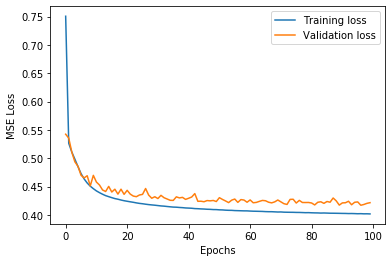

In [8]:
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [32]:
compute_weighted_rmse(pred, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z_rmse   float64 650.1
    t_rmse   float64 3.017

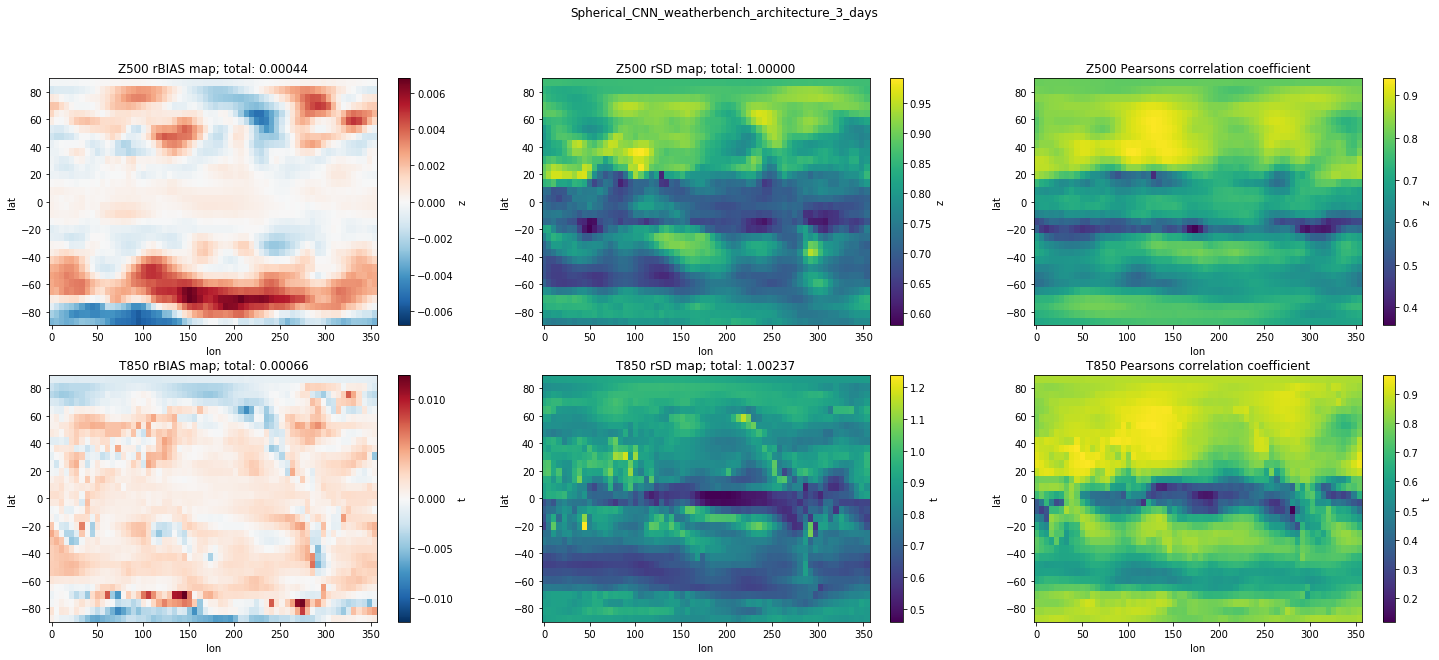

In [35]:
assess_model(pred, valid, evaluation_path, 'Spherical_CNN_weatherbench_architecture_3_days')